PRÉ PROCESSAMENTO, BALANCEAMENTO E SALVAMENTO DA SAMPLE:

In [2]:
import pandas as pd
import numpy as np

files = [
    "Thuesday-20-02-2018_TrafficForML_CICFlowMeter.csv",
    "Wednesday-21-02-2018_TrafficForML_CICFlowMeter.csv",
]

# -----------------------------
# Colunas relevantes
# -----------------------------
cols_to_keep = [
    'Label', 'Protocol', 'Src Port', 'Dst Port',
    'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts',
    'TotLen Fwd Pkts', 'TotLen Bwd Pkts',
    'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean',
    'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
    'FIN Flag Cnt', 'SYN Flag Cnt', 'PSH Flag Cnt',
    'ACK Flag Cnt', 'URG Flag Cnt', 'ECE Flag Cnt'
]

chunk_size = 200000
dfs = []

# -----------------------------
# Ler em chunks e acumular
# -----------------------------
for file in files:
    for chunk in pd.read_csv(file, chunksize=chunk_size, low_memory=False):
        chunk.columns = [c.strip() for c in chunk.columns]
        cols_existentes = [c for c in cols_to_keep if c in chunk.columns]
        chunk = chunk[cols_existentes]
        chunk['Label'] = chunk['Label'].astype(str).str.strip()
        chunk = chunk[chunk['Label'] != 'nan']
        dfs.append(chunk)

# Concatenar todos os chunks
df = pd.concat(dfs, ignore_index=True)
del dfs
print("Shape após concatenação:", df.shape)

# -----------------------------
# Converter colunas numéricas
# -----------------------------
for col in df.columns:
    if col != 'Label':
        df[col] = pd.to_numeric(df[col], errors='coerce')

# -----------------------------
# Transformar Label em binária (0 = benigno, 1 = ataque)
# -----------------------------
df['Label'] = np.where(df['Label'].str.lower() == 'benign', 0, 1)

# -----------------------------
# Remover linhas com Label ausente
# -----------------------------
df = df.dropna(subset=['Label'])
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# -----------------------------
# Preencher NaN nas colunas numéricas com a mediana
# -----------------------------
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

# -----------------------------
# Remover features altamente correlacionadas
# -----------------------------
num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c != 'Label']
corr_matrix = df[num_cols].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
threshold = 0.95
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
if to_drop:
    print(f"Colunas com correlação > {threshold} que serão removidas ({len(to_drop)}):")
    print(to_drop)
    df = df.drop(columns=to_drop)
else:
    print("Nenhuma coluna altamente correlacionada encontrada acima do threshold.")

num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c != 'Label']

# -----------------------------
# Checagem rápida
# -----------------------------
counts = df['Label'].value_counts()
print("Contagem após limpeza (0=benign,1=attack):")
print(counts)

# -----------------------------
# Criar amostra balanceada (600.000 linhas)
# -----------------------------
n_total = 600000
n_benign = int(n_total * 0.9)
n_ddos = n_total - n_benign

if counts.get(0, 0) < n_benign or counts.get(1, 0) < n_ddos:
    raise ValueError(
        f"Não há exemplos suficientes: benignos={counts.get(0,0)}, ataques={counts.get(1,0)}. "
        "Ajuste n_total ou revise os arquivos lidos."
    )

df_benign = df[df['Label'] == 0].sample(n=n_benign, random_state=42)
df_ddos = df[df['Label'] == 1].sample(n=n_ddos, random_state=42)

df_sample = pd.concat([df_benign, df_ddos], ignore_index=True)
df_sample = df_sample.sample(frac=1, random_state=42)  # embaralhar

# -----------------------------
# Remover duplicatas do df_sample
# -----------------------------
df_sample = df_sample.drop_duplicates().reset_index(drop=True)
print("Shape da amostra final, após remoção de duplicatas:", df_sample.shape)
print("Distribuição da coluna Label (0 = benigno, 1 = ataque):")
print(df_sample['Label'].value_counts())

# -----------------------------
# Salvar a amostra final
# -----------------------------
df_sample.to_csv("df_sample.csv", index=False)
print("Arquivo df_sample.csv salvo com sucesso!")

Shape após concatenação: (8997323, 21)
Colunas com correlação > 0.95 que serão removidas (2):
['TotLen Fwd Pkts', 'TotLen Bwd Pkts']
Contagem após limpeza (0=benign,1=attack):
Label
0    7733390
1    1263933
Name: count, dtype: int64
Shape da amostra final, após remoção de duplicatas: (584227, 19)
Distribuição da coluna Label (0 = benigno, 1 = ataque):
Label
0    535925
1     48302
Name: count, dtype: int64
Arquivo df_sample.csv salvo com sucesso!


Análise exploratória da Sample

Shape do df_sample: (593266, 18)

Colunas presentes:
['Src Port', 'Dst Port', 'Subflow Fwd Byts', 'Fwd IAT Tot', 'Fwd Pkt Len Max', 'Fwd Seg Size Avg', 'Flow IAT Min', 'Flow Pkts/s', 'Bwd Seg Size Avg', 'Fwd IAT Max', 'ACK Flag Cnt', 'Flow IAT Std', 'Tot Bwd Pkts', 'Pkt Len Std', 'Init Bwd Win Byts', 'Fwd Seg Size Min', 'Bwd Pkts/s', 'Label']

Tipos de dados:
float64    11
int64       7
Name: count, dtype: int64

Duplicatas: 8

Distribuição da coluna Label (0 = benign, 1 = ataque):
Label
0    567253
1     26013
Name: count, dtype: int64

Estatísticas descritivas (colunas numéricas):
            Src Port       Dst Port  Subflow Fwd Byts   Fwd IAT Tot  \
count  593266.000000  593266.000000      5.932660e+05  5.932660e+05   
mean    45323.219756    9661.062421      8.165959e+02  1.257847e+07   
std     20695.495773   19832.860836      4.047855e+04  3.219944e+07   
min         0.000000       0.000000      0.000000e+00  0.000000e+00   
25%     49784.000000      53.000000      2.800000e+01  

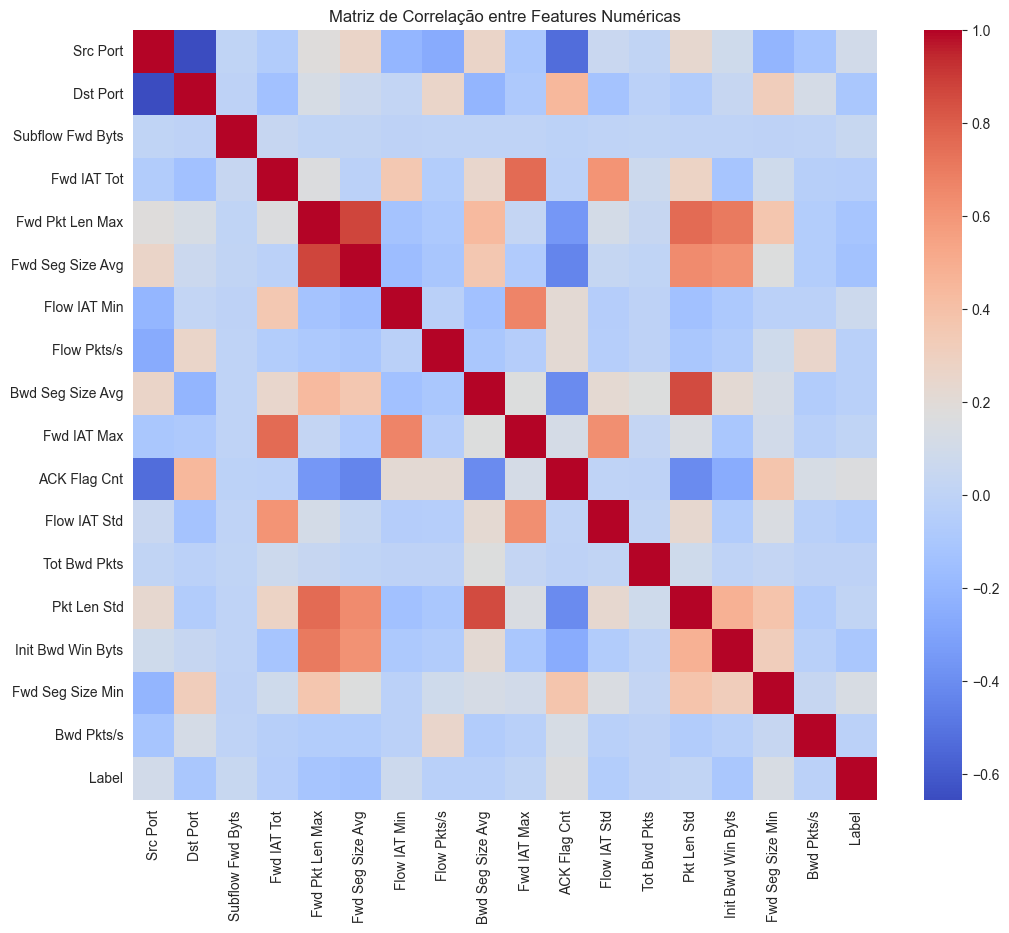

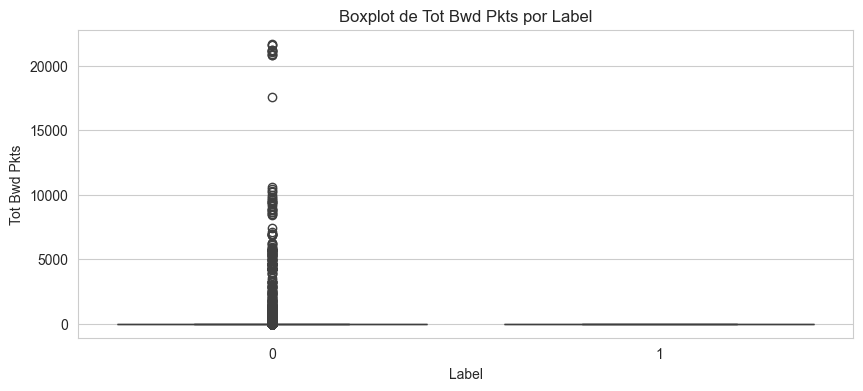

KeyError: 'Tot Fwd Pkts'

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
# ==============================
# 1. Carregar df_sample
# ==============================
df = pd.read_csv("df_sample.csv")
print("Shape do df_sample:", df.shape)
print("\nColunas presentes:")
print(df.columns.tolist())

# ==============================
# 2. Diagnóstico geral
# ==============================
# Tipos de dados
print("\nTipos de dados:")
print(df.dtypes.value_counts())

# Contagem de duplicatas
print("\nDuplicatas:", df.duplicated().sum())

# Distribuição do Label
print("\nDistribuição da coluna Label (0 = benign, 1 = ataque):")
print(df['Label'].value_counts())

# ==============================
# 3. Estatísticas descritivas
# ==============================
print("\nEstatísticas descritivas (colunas numéricas):")
print(df.describe())



# ==============================
# 4. Correlação entre features numéricas
# ==============================
corr_matrix = df[num_cols].corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title("Matriz de Correlação entre Features Numéricas")
plt.show()

# ==============================
# 5. Outliers (boxplots)
# ==============================
cols_outlier_check = ['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts',
                      'TotLen Fwd Pkts', 'TotLen Bwd Pkts']

for col in cols_outlier_check:
    if col in df.columns:
        plt.figure(figsize=(10,4))
        sns.boxplot(x='Label', y=col, data=df)
        plt.title(f"Boxplot de {col} por Label")
        plt.show()

# ==============================
# 6. Distribuição Forward/Backward Packets
# ==============================
df['Fwd/Bwd Packet Ratio'] = df['Tot Fwd Pkts'] / (df['Tot Bwd Pkts'] + 1)
print("\nEstatísticas da Razão Fwd/Bwd Packets:")
print(df['Fwd/Bwd Packet Ratio'].describe())


# ==============================
# 7. Flags TCP
# ==============================
tcp_flags = ['FIN Flag Cnt','SYN Flag Cnt','PSH Flag Cnt','ACK Flag Cnt',
             'URG Flag Cnt','CWE Flag Count','ECE Flag Cnt']

for flag in tcp_flags:
    if flag in df.columns:
        print(f"\nEstatísticas da {flag} por Label:")
        print(df.groupby('Label')[flag].describe())


# ==============================
# 8. Top 20 portas mais usadas
# ==============================
for col in ['Src Port', 'Dst Port']:
    if col in df.columns:
        top_ports = df[col].value_counts().head(20)
        print(f"\nTop 20 {col}s:")
        print(top_ports)



# ==============================
# 10. Protocolos presentes
# ==============================
if 'Protocol' in df.columns:
    protocol_counts = df['Protocol'].value_counts()
    print("\nProtocolos presentes e contagens:")
    print(protocol_counts)

